# Banana Navigator

---

This notebook uses the Unity ML-Agents environment for the first project of the Udacity [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)

## Import Packages

Ensure you have followed the setup instructions from the README before importing these packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch

## Initialize Environment

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded during the README setup:

- **Mac**: `'path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

You can also watch the agent visually in the Unity Environment. I opted not to by specifying `no_graphics=True` below because my computer has trouble running the environment.

The environment also has a brain that we can use to control our agent.

In [2]:
env = UnityEnvironment(file_name='Banana.app', no_graphics=True) # uses file name for Mac
# env = UnityEnvironment(file_name='Banana.app') # opens Unity environment to watch agent visually

brain_name = env.brain_names[0] # get the default brain

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Untrained Agent

See how an untrained performs with random actions

In [3]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]

score = 0
step = 1

while True:
    action = np.random.randint(4)
    env_info = env.step(action)[brain_name] # perform random action
    score += env_info.rewards[0]
    state = env_info.vector_observations[0]

    print('\rStep ' + str(step), end='')
    step += 1

    if env_info.local_done[0]:
        break
    
print('\nScore: ' + str(score))

Step 300
Score: -1.0


## Initialize Agent

Instantiate the agent we'll use for sampling + training and/or running the trained agent

In [4]:
from agent import Agent
from dueling_q_network import DuelingQNetwork
from q_network import QNetwork

# Instantiate an agent with either dueling or normal architecture
agent = Agent(state_size=37, action_size=4, network=DuelingQNetwork, seed=0)
# agent = Agent(state_size=37, action_size=4, network=QNetwork, seed=0)

## Sampling Phase

Collects experiences for later experience replay when training our agent

In [5]:
for q in range(1, 3): # 2 sampling episodes
    print('Sampling episode ' + str(q))
    env_info = env.reset(train_mode=False)[brain_name]

    for r in range(1, 201): # each episode capped at 200 steps
        state = env_info.vector_observations[0]
        action = agent.act(state)
        env_info = env.step(action)[brain_name] # perform action chosen by agent

        if env_info.local_done[0] or r == 200:
            print('\rStep ' + str(r))
            break
        else:
            print('\rStep ' + str(r), end='')

Sampling episode 1
Step 200
Sampling episode 2
Step 200


## Training Phase

Trains the agent to collect bananas efficiently

In [6]:
from collections import deque

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []
    scores_window = deque(maxlen=100) # last 100 scores
    eps = eps_start
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name] # perform action chosen by agent
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps) # update epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end='')
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    torch.save(agent.qnetwork_local.state_dict(), 'weights.pth')

    return scores

scores = dqn()

Episode 100	Average Score: 0.64
Episode 200	Average Score: 4.66
Episode 300	Average Score: 7.85
Episode 400	Average Score: 9.06
Episode 500	Average Score: 11.66
Episode 600	Average Score: 12.90
Episode 700	Average Score: 13.80
Episode 800	Average Score: 13.71
Episode 900	Average Score: 15.26
Episode 1000	Average Score: 15.41
Episode 1100	Average Score: 15.44
Episode 1200	Average Score: 16.77
Episode 1300	Average Score: 17.28
Episode 1400	Average Score: 17.60
Episode 1500	Average Score: 17.31
Episode 1600	Average Score: 16.97
Episode 1700	Average Score: 16.87
Episode 1800	Average Score: 16.35
Episode 1900	Average Score: 16.59
Episode 2000	Average Score: 15.70


## Visualize Results

Plots a recap of the training phase

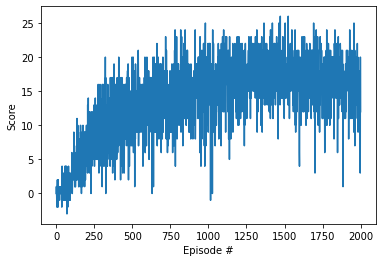

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Watch a Trained Agent

See how a trained performs over 10 episodes with weights loaded from the training phase

In [12]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('weights.pth'))

n_episodes = 10

score = 0.0

for q in range(1, n_episodes + 1):
    print('\rEpisode ' + str(q), end='')

    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]

    while True:
        action = agent.act(state)
        env_info = env.step(action)[brain_name] # perform random action
        score += env_info.rewards[0]
        state = env_info.vector_observations[0]

        if env_info.local_done[0]:
            break
    
print('\nAverage score: ' + str(score / n_episodes))

Episode 10
Average score: 16.0


## Close Environment
If you close the environment and want to interact with the environment again, you'll have to restart the kernel first

In [13]:
env.close()